In [2]:
from IPython.display import display
from sympy import *
from sympy.simplify.cse_main import cse  # Common Sub-Expressions
init_printing()

In [3]:
m, J, B, B_r, B_s, B_l, S_l = var('m, J, B, B_r, B_s, B_l, S_l', positive=True, real=True)
w0, v0, a0, x0, y0, F_l, F_r, t = var('w0, v0, a0, x0, y0, F_l, F_r, t', real=True)

In [26]:
# When not turning
v = Function('v')
eqn = Eq(v(t).diff(t), (F_l + F_r + B_r*v(t))/m)
sln = dsolve(eqn, v(t))
display(sln)
v2 = solve(sln, v(t))[0]

In [17]:
# Find constant of integration
C = [s for s in v2.free_symbols if s.name.startswith('C')][0]
C = {C: solve(Eq(v2.subs({t: 0}), v0), C)[0]}
v2.subs(C).simplify()

In [46]:
v, C = var('v, C', real=True)
v = solve(t - integrate(m/(F_l + F_r + B_r*v), v), v)[0] + C
Cval = solve(v.subs({t: 0}) - v0, C)[0]
v = v.subs({C: Cval}).simplify()
display(v)

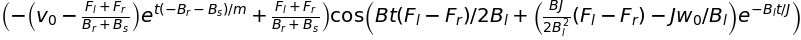

KeyboardInterrupt: 

In [53]:
A0 = (F_l+F_r)/(B_r+B_s)
A1 = B/2*(F_l-F_r)/B_l
dxdt = ((A0 - (v0-A0)*exp(-(B_r+B_s)*t/m)) *
        cos(A1*t + (A1/B_l*J-w0*J/B_l)*exp(-B_l*t/J)))
display(dxdt)
x = integrate(dxdt, t)
display(x)

terms, expr = x.cse()
display(terms)
display(expr)

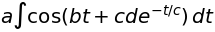

CPU times: user 10.8 s, sys: 13.3 ms, total: 10.8 s
Wall time: 10.8 s


In [57]:
%%time
a, b, c, d, t = var('a, b, c, d, t')
display(integrate(a*cos(b*t+c*d*exp(-t/c)), t).doit())

In [68]:
from scipy.integrate import quad, odeint
import numpy as np

# From Nutaro, Table 2.1
m = 0.8  # kg
J = 5e-4  # kg m**2
B = 2.8
Br = 1.  # Rolling friction, N s / m
Bs = 14.  # Sliding friction, N s / m
Bl = 0.7  # Turning friction, N m s / rad
Sl = 0.3  # Lateral friction, N m

Fr = 0.6
Fl = 0.2

dt = 0.01

A = (Fr + Fl) / (Br + Bs)
v0 = 0
v = A + (v0 - A) * np.exp(-(Br+Bs) * dt / m)
r = (A * dt + m / (Br + Bs) * (v0/(Br + Bs) - A) *
     (np.exp(-(Br + Bs) * dt / m) - 1))

w0 = 0.
w = (A - (A - Bl*w0) * np.exp(-Bl*dt/J)) / Bl
# Integrate to get orientation, a
# w = da/dt = (B/2*(Fl-Fr)-(B/2*(Fl-Fr)-Bl*w0)*exp(-Bl*t/J))/Bl
# a = (B/2*(Fl-Fr)*t +
#     (B/2*(Fl-Fr)/Bl*J-w0*J)*exp(-Bl*t/J))/Bl
yaw = ((A*dt + J*(A/Bl - w0) *
       np.exp(-Bl*dt/J))/Bl)

# dx/dt = v(t) * cos(a(t)) : differs in convention from Nutaro
# A0 = (Fl+Fr)/(Br+Bs)
# A1 = B/2*(Fl-Fr)/Bl
# dx/dt = (A0 - (v0-A0)*exp(-(Br+Bs)*t/m)) *
#         cos(A1*t + (A1/Bl*J-w0*J/Bl)*exp(-Bl*t/J))
# dx/dt may not be analytically integrable
# but we can solve the problem numerically
# dy/dt = v(t) * sin(a(t))
# dy/dt = (A0 - (v0-A0)*exp(-(Br+Bs)*t/m)) *
#         sin(A1*t + (A1/Bl*J-w0*J/Bl)*exp(-Bl*t/J))
def x_ode(t):
    A0 = (Fl+Fr)/(Br+Bs)
    A1 = B/2*(Fl-Fr)/Bl
    dxdt = ((A0 - (v0-A0)*exp(-(Br+Bs)*t/m)) *
            cos(A1*t + (A1/Bl*J-w0*J/Bl)*exp(-Bl*t/J)))
    return dxdt

# odeint(x_ode, 0, [0, dt])
x, err = quad(x_ode, 0, dt)
print(x)
print(err)

0.0010196398427957563
1.1320276302970237e-17
